In [1]:
# solo para uso en colab
from google.colab import drive
drive.mount('/content/drive')
import sys
import os
path= '/content/drive/MyDrive/codigos/Anal-tica-en-Recursos-Humanos'
os.chdir(path)
sys.path.append(path+'/')

Mounted at /content/drive


In [2]:
import os
import sys

ruta =os.getcwd()
sys.path.append(ruta)

In [3]:
import warnings
warnings.filterwarnings("ignore")



# Importar librerias necesarias
import sqlite3 as sql
import pandas as pd
import a_funciones as fn ### importar modulo de  funciones
from a_funciones import * ### importar toddas llas funciones del archivo

from sklearn import linear_model ## para regresión lineal
from sklearn import tree ###para ajustar arboles de decisión
from sklearn.ensemble import RandomForestRegressor ##Ensamble con bagging
from sklearn.ensemble import GradientBoostingRegressor ###Ensamble boosting
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn import metrics

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.model_selection import RandomizedSearchCV
import joblib  ### para guardar modelos
from sklearn.preprocessing import StandardScaler ## escalar variables
#import openpyxl

In [4]:
#### conectarse a base de datos preprocesada

con=sql.connect('bases de datos RRHH/datos.db')
cur=con.cursor()

In [5]:
pd.read_sql(""" select * from completo""", con=con)

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeID,Gender,JobLevel,JobRole,...,JobSatisfaction,WorkLifeBalance,DateSurvey,JobInvolvement,PerformanceRating,SurveyDate,Attrition,retirementDate,retirementType,resignationReason
0,51,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,Healthcare Representative,...,4.0,2.0,2015-12-31,3,3,2015-12-31,0,0,NoRetirement,NoRetirement
1,31,Travel_Frequently,Research & Development,10,1,Life Sciences,2,Female,1,Research Scientist,...,2.0,4.0,2015-12-31,2,4,2015-12-31,1,2016-10-15,Resignation,Others
2,32,Travel_Frequently,Research & Development,17,4,Other,3,Male,4,Sales Executive,...,2.0,1.0,2015-12-31,3,3,2015-12-31,0,0,NoRetirement,NoRetirement
3,38,Non-Travel,Research & Development,2,5,Life Sciences,4,Male,3,Human Resources,...,4.0,3.0,2015-12-31,2,3,2015-12-31,0,0,NoRetirement,NoRetirement
4,32,Travel_Rarely,Research & Development,10,1,Medical,5,Male,1,Sales Executive,...,1.0,3.0,2015-12-31,3,3,2015-12-31,0,0,NoRetirement,NoRetirement
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8815,42,Travel_Rarely,Research & Development,5,4,Medical,4406,Female,1,Research Scientist,...,1.0,3.0,2016-12-31,3,3,2016-12-31,0,0,NoRetirement,NoRetirement
8816,29,Travel_Rarely,Research & Development,2,4,Medical,4407,Male,1,Laboratory Technician,...,4.0,3.0,2016-12-31,2,3,2016-12-31,0,0,NoRetirement,NoRetirement
8817,25,Travel_Rarely,Research & Development,25,2,Life Sciences,4408,Male,2,Sales Executive,...,3.0,3.0,2016-12-31,3,4,2016-12-31,0,0,NoRetirement,NoRetirement
8818,42,Travel_Rarely,Sales,18,2,Medical,4409,Male,1,Laboratory Technician,...,1.0,3.0,2016-12-31,2,3,2016-12-31,0,0,NoRetirement,NoRetirement


In [6]:
df_completo = pd.read_sql(""" select * from completo""", con=con)

# **Análisis Exploratorio**

##### La variable objetivo es Atrition, vamos a explorar cómo está distribuida, y su segmenación por edad y análisis de matriz de correlación

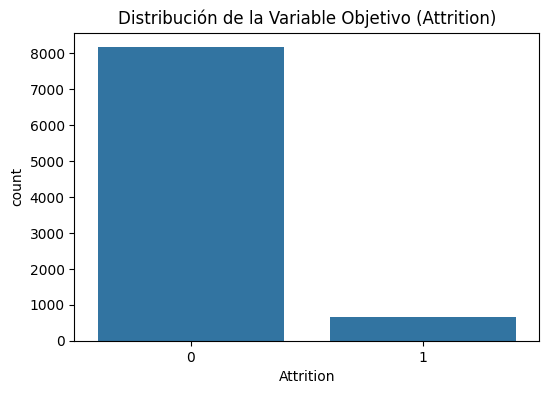

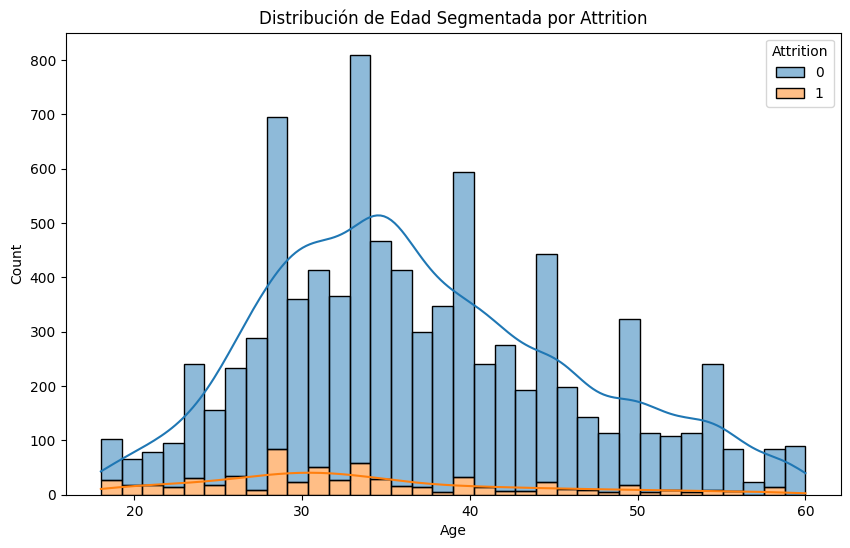

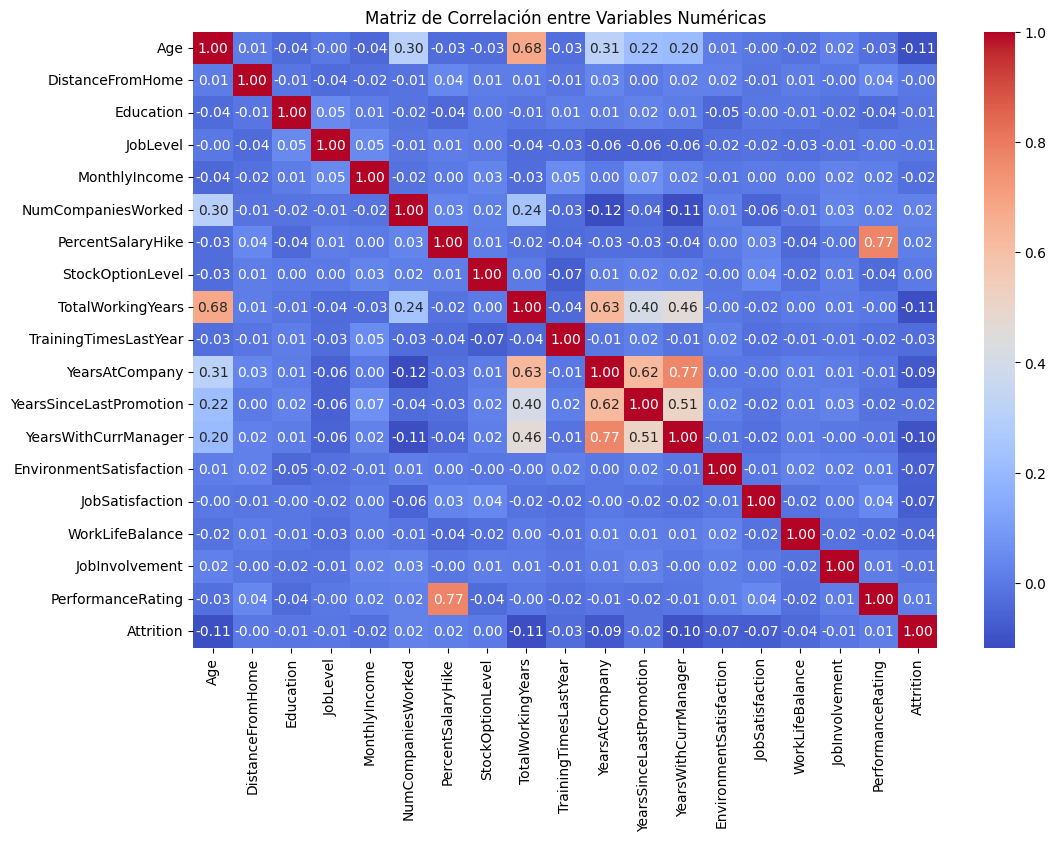

In [7]:
# Distribución de la variable objetivo (Attrition)
plt.figure(figsize=(6,4))
sns.countplot(x='Attrition', data=df_completo)
plt.title('Distribución de la Variable Objetivo (Attrition)')
plt.show()

# Distribución de Age segmentada por Attrition
plt.figure(figsize=(10,6))
sns.histplot(data=df_completo, x='Age', hue='Attrition', multiple='stack', kde=True)
plt.title('Distribución de Edad Segmentada por Attrition')
plt.show()

# Filtrar solo las columnas numéricas
df_numerico = df_completo.select_dtypes(include=['float64', 'int64'])

# calcular la matriz de correlación
plt.figure(figsize=(12,8))
corr_matrix = df_numerico.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matriz de Correlación entre Variables Numéricas')
plt.show()


* Hay un pico de empleados jóvenes (en sus  30s) que tienen una mayor propensión a dejar la empresa. Esto podría sugerir que la edad y la experiencia juegan un papel importante en la rotación. Exploraremos que causa de fondo puede haber.
* La variable Attrition muestra correlaciones relativamente bajas con otras variables numéricas, lo que sugiere que la rotación puede estar más influenciada por variables categóricas o interacciones complejas entre variables.

##### Distribucion de género y edad:
* ¿la empresa es equitativa en la distribución del género de sus empleados
* ¿ Cómo está distribuido el género en la rotación de los mismos?
* ¿Cómo se distribuye la edad en los empleados que se retiran de la compañía?

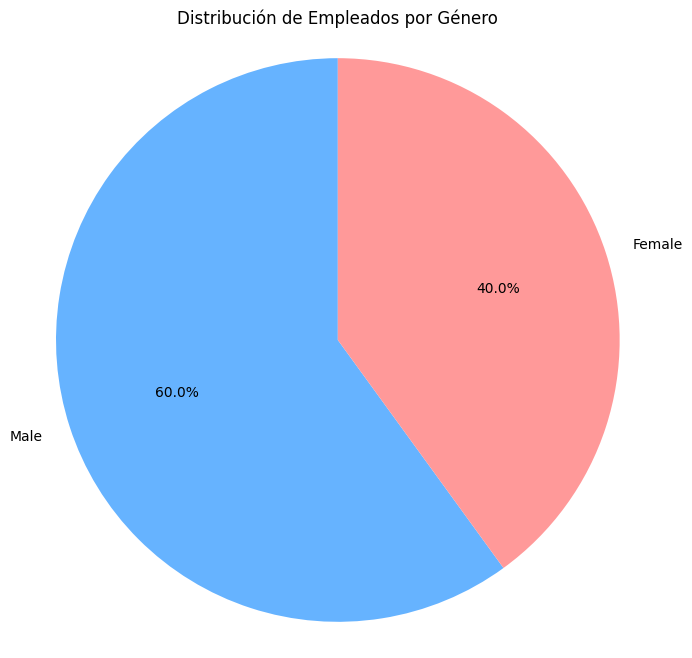

In [8]:
# Calcular la distribución de empleados por género
gender_counts = df_completo['Gender'].value_counts()
gender_percentages = gender_counts / gender_counts.sum() * 100

# Crear el diagrama de torta
plt.figure(figsize=(8, 8))
plt.pie(gender_percentages, labels=gender_percentages.index, autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'], startangle=90)
plt.title('Distribución de Empleados por Género')
plt.axis('equal')  # Asegura que el gráfico sea circular
plt.show()


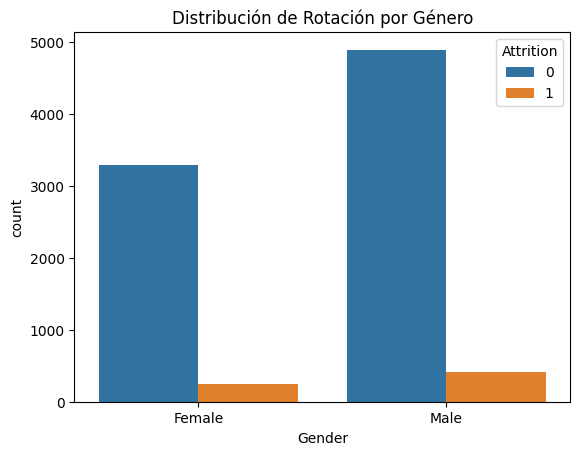

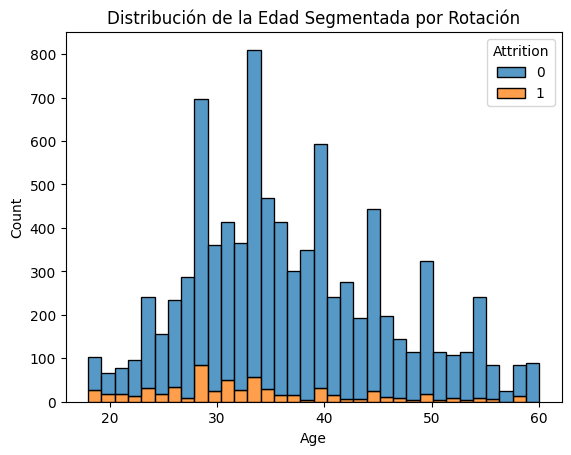

In [9]:
sns.countplot(data=df_completo, x='Gender', hue='Attrition')
plt.title('Distribución de Rotación por Género')
plt.show()
sns.histplot(data=df_completo, x='Age', hue='Attrition', multiple='stack')
plt.title('Distribución de la Edad Segmentada por Rotación')
plt.show()

* El 60% de los empleados son hombres, mientras que el 40% son mujeres. Esto indica una mayor representación masculina dentro de la empresa.
* En términos absolutos, la rotación (attrition) es mayor en los hombres debido a que representan una proporción más grande de la empresa.
* La mayoría de los empleados que dejan la empresa se encuentran en rangos de edad entre los 25 y 35 años, lo que podría indicar que los empleados más jóvenes son más propensos a abandonar la compañía. La empresa podría considerar estrategias dirigidas a empleados jóvenes (especialmente entre los 25-35 años), como desarrollo de carrera o mejoras en la satisfacción laboral, para reducir su tasa de rotación.

##### Análisis de variables relacionadas con el salario segmentadas por edad y rotación

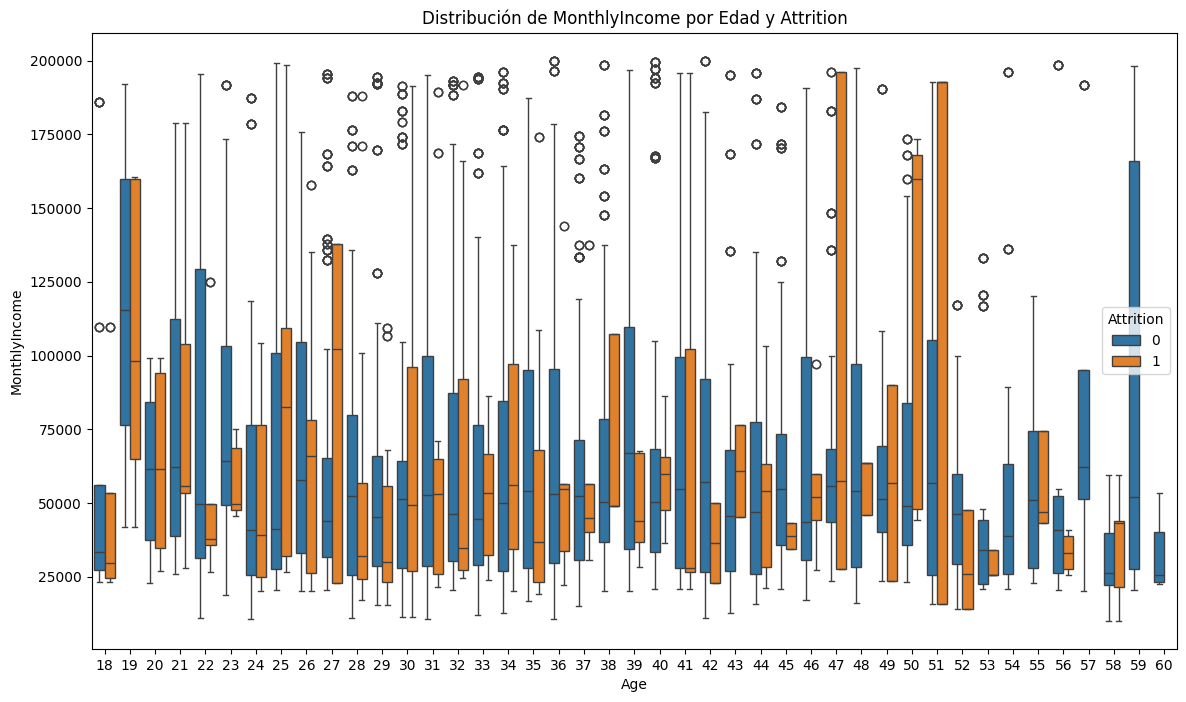

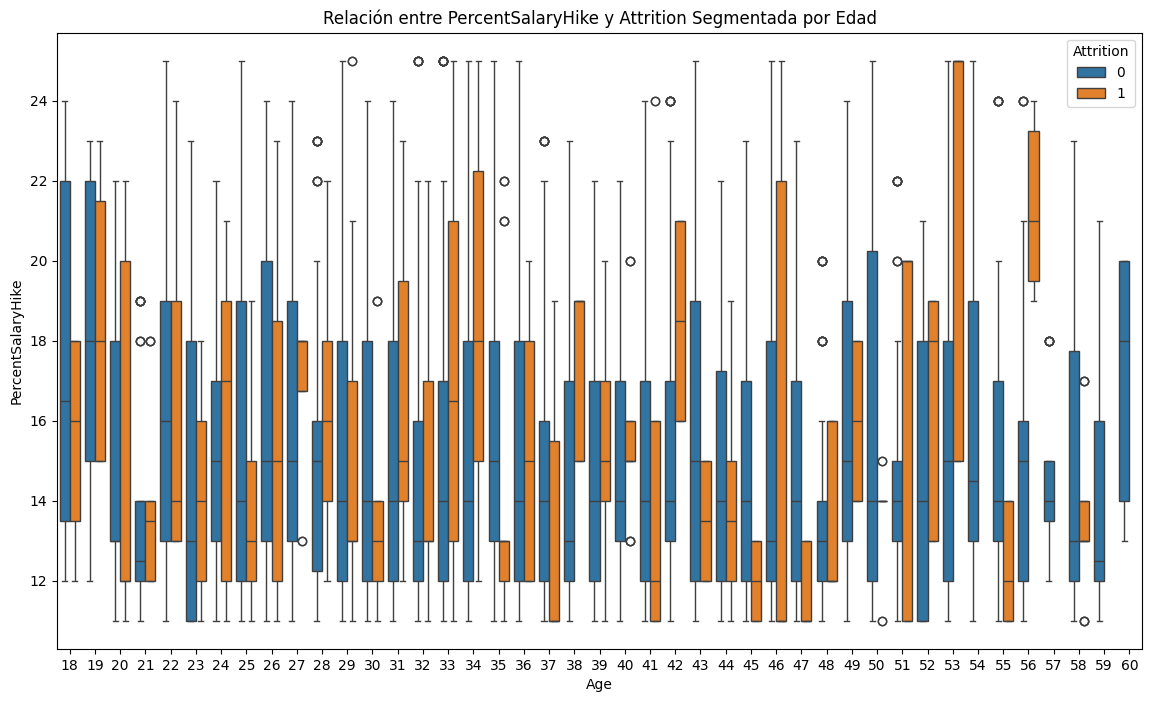

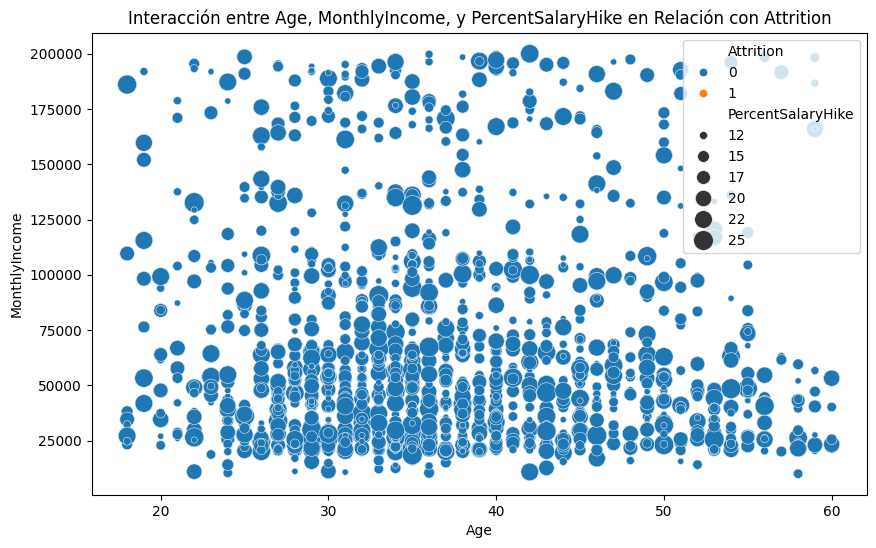

In [10]:
# 1. Distribución de MonthlyIncome segmentada por Age y Attrition
plt.figure(figsize=(14,8))
sns.boxplot(x='Age', y='MonthlyIncome', hue='Attrition', data=df_completo)
plt.title('Distribución de MonthlyIncome por Edad y Attrition')
plt.show()

# 2. Relación entre PercentSalaryHike y Attrition segmentada por Age
plt.figure(figsize=(14,8))
sns.boxplot(x='Age', y='PercentSalaryHike', hue='Attrition', data=df_completo)
plt.title('Relación entre PercentSalaryHike y Attrition Segmentada por Edad')
plt.show()

# 3. Análisis de interacción entre Age, MonthlyIncome y PercentSalaryHike
plt.figure(figsize=(10,6))
sns.scatterplot(x='Age', y='MonthlyIncome', hue='Attrition', size='PercentSalaryHike', data=df_completo, sizes=(20, 200))
plt.title('Interacción entre Age, MonthlyIncome, y PercentSalaryHike en Relación con Attrition')
plt.show()


* En algunos grupos de edad (por ejemplo, alrededor de los 40 años), se observa que tanto los que se quedan como los que se van tienen una distribución de ingresos similar, lo que sugiere que el ingreso mensual por sí solo puede no ser un factor determinante en la decisión de renunciar
* No parece haber una diferencia clara en los aumentos salariales porcentuales entre aquellos que se quedan y aquellos que se van, lo que podría indicar que otros factores, (como la satisfacción laboral o el entorno de trabajo), juegan un papel más importante en la decisión de renunciar
* El gráfico de dispersión muestra que los empleados con diferentes combinaciones de edad, ingresos mensuales y aumentos salariales pueden decidir quedarse o irse, lo que sugiere una interacción compleja entre estas variables

##### Análisis de las razones de renuncia:
* ¿Cuál es el mayor motivo de las renuncias?
* ¿Con qué frecuencia se dan?

In [11]:
# Filtrar el DataFrame para excluir los casos de "NoRetirement"
df_retiro_filtrado = df_completo[df_completo['resignationReason'] != 'NoRetirement']

# Contar la cantidad de renuncias por motivo
razones_renuncia = df_retiro_filtrado['resignationReason'].value_counts()

# Calcular los porcentajes
porcentajes_renuncia = (razones_renuncia / razones_renuncia.sum()) * 100

# Crear un DataFrame para mostrar las razones y sus porcentajes
df_razones = pd.DataFrame({
    'Frecuencia': razones_renuncia,
    'Porcentaje (%)': porcentajes_renuncia
})

# Mostrar los resultados
print("Razones de renuncia, su frecuencia y porcentaje:")
print(df_razones)


Razones de renuncia, su frecuencia y porcentaje:
                   Frecuencia  Porcentaje (%)
resignationReason                            
Others                    296       45.538462
Salary                    173       26.615385
Stress                    116       17.846154
Fired                      65       10.000000


* Others: Es la razón más común para la renuncia, representando el 45.54% de los casos. Esto indica que una gran parte de las renuncias no se puede atribuir directamente a razones específicas.
* Salario: Con un 26.62%, las renuncias debido al salario son la segunda razón más frecuente. Esto subraya la importancia de revisar las políticas salariales y compararlas con el mercado para asegurarse de que los empleados se sientan adecuadamente compensados.
* Estrés: El estrés laboral es responsable del 17.85% de las renuncias. Este porcentaje indica que una proporción significativa de empleados deja la empresa debido a la presión laboral. Se pueden implementar programas de bienestar y soporte para reducir el estrés laboral, atacando así ese porcentaje de renuncias
* Despido: Aunque los despidos representan solo el 10% de las renuncias, sigue siendo un número considerable que podría estar relacionado con problemas de desempeño.

##### Análisis de renuncias por departamento y nivel educativo
¿Qué departamentos de la empresa presenta más renuncias y cuál es su distribución?
¿Cuál es el nivel educativo que presenta más renuncias?

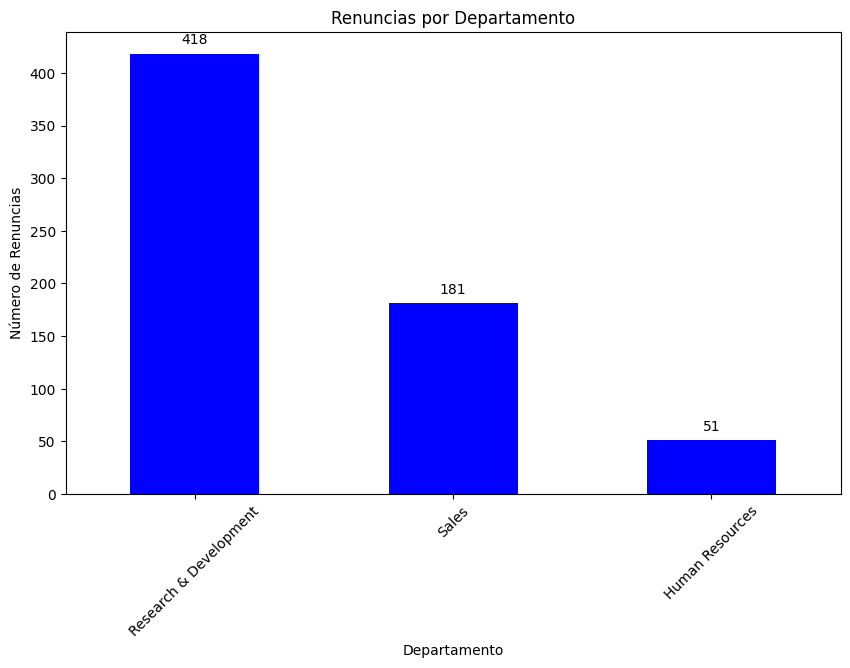

In [12]:
# Contar la cantidad de renuncias por departamento
renuncias_departamento = df_completo[df_completo['Attrition'] == 1]['Department'].value_counts()

# Crear la figura
plt.figure(figsize=(10, 6))

# Generar el gráfico de barras
ax = renuncias_departamento.plot(kind='bar', color='blue')

# Añadir el título y etiquetas
plt.title('Renuncias por Departamento')
plt.xlabel('Departamento')
plt.ylabel('Número de Renuncias')

# Añadir los valores en la parte superior de cada barra
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Rotar las etiquetas del eje x si es necesario
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()

* Research & Development (I+D) es el departamento con más renuncias (418). Esto podría indicar problemas relacionados con la carga de trabajo, el ambiente laboral, o las oportunidades de crecimiento en este departamento.
* Sales también muestra un número considerable de renuncias con 181 empleados que dejaron la empresa, lo cual puede reflejar presiones de desempeño o insatisfacción con las comisiones y objetivos.
* Human Resources tiene un número significativamente menor de renuncias (51), lo que podría sugerir que este departamento tiene una mejor retención de empleados o que enfrenta menos desafíos en comparación con los otros departamentos.

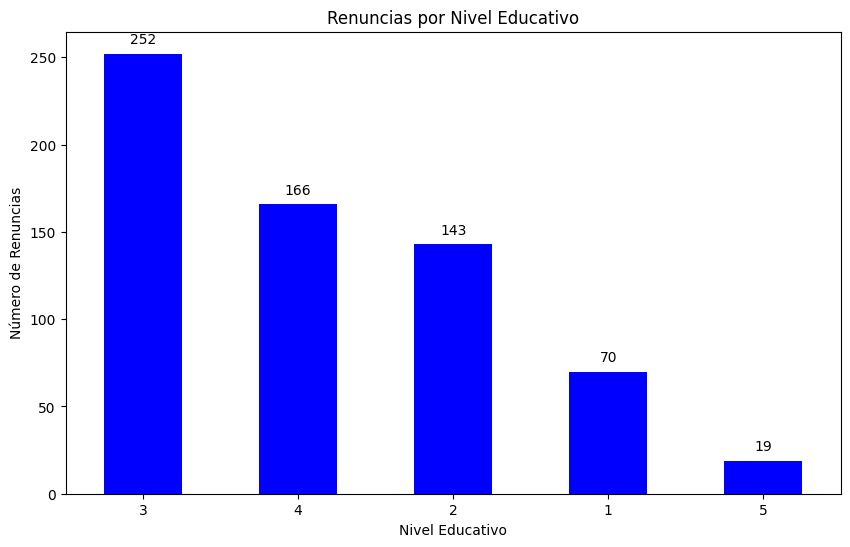

In [13]:
# Contar la cantidad de renuncias por nivel educativo
renuncias_educativo = df_completo[df_completo['Attrition'] == 1]['Education'].value_counts()

# Crear la figura
plt.figure(figsize=(10, 6))

# Generar el gráfico de barras
ax = renuncias_educativo.plot(kind='bar', color='blue')

# Añadir el título y etiquetas
plt.title('Renuncias por Nivel Educativo')
plt.xlabel('Nivel Educativo')
plt.ylabel('Número de Renuncias')

# Añadir los valores en la parte superior de cada barra
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Rotar las etiquetas del eje x si es necesario
plt.xticks(rotation=0)

# Mostrar el gráfico
plt.show()

la mayoría de las renuncias provienen de empleados con un nivel educativo de "3" (pregrado universitario), seguido de los niveles "4" (Maestría) y "2" (pregrado parcial o incompleto). Esto indicar que los empleados con  niveles educativos medios son más propensos a dejar la empresa.

##### Clustering

Para realizar una segmentación avanzada,utilizaremos técnicas como el clustering. Usaremos el algoritmo K-Means, para agrupar los empleados en diferentes clusters basados en sus características. Esto nos permitirá identificar grupos de empleados con características similares, lo que podría revelar patrones ocultos en los datos relacionados con la rotación.

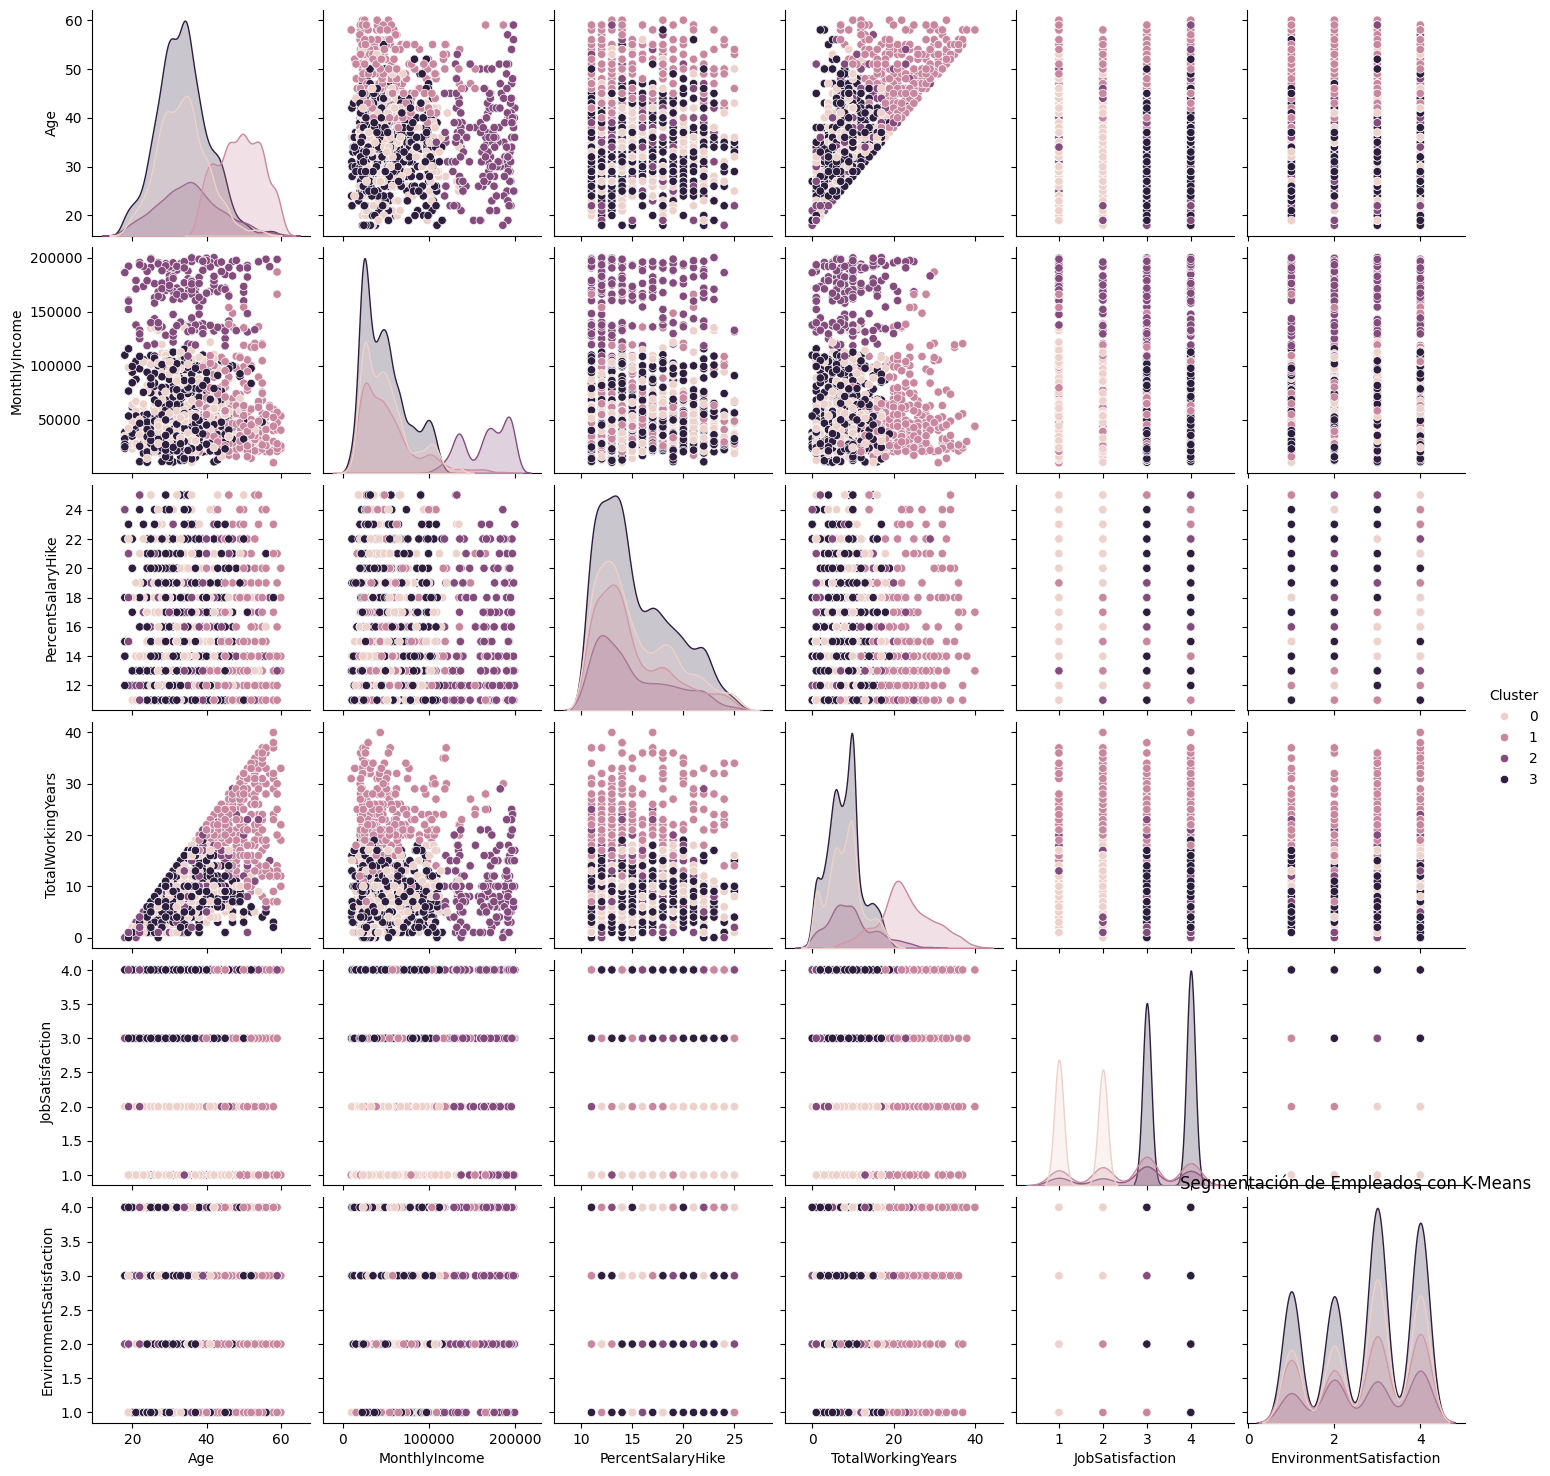

In [14]:
# 1. Selección de variables relevantes para el clustering
variables_seleccionadas = ['Age', 'MonthlyIncome', 'PercentSalaryHike', 'TotalWorkingYears', 'JobSatisfaction', 'EnvironmentSatisfaction']

# Crear un nuevo DataFrame con solo las variables seleccionadas
df_clustering = df_completo[variables_seleccionadas].dropna()

# 2. Preprocesamiento: Escalamiento de los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clustering)

# 3. Aplicación de K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)  # Cambia n_clusters según lo necesario
df_clustering['Cluster'] = kmeans.fit_predict(df_scaled)

# 4. Visualización de los Resultados
# Visualización usando las primeras dos componentes principales (PCA)
sns.pairplot(df_clustering, hue='Cluster', vars=variables_seleccionadas)
plt.title('Segmentación de Empleados con K-Means')
plt.show()

Descripción de los clusters:
               Age  MonthlyIncome  PercentSalaryHike  TotalWorkingYears  \
Cluster                                                                   
0        33.534864   50543.316327          15.274660           8.102891   
1        48.867110   52987.508306          14.903654          22.942414   
2        35.329730  165970.756757          15.108108           9.670270   
3        33.593468   49199.797297          15.353604           7.946509   

         JobSatisfaction  EnvironmentSatisfaction  
Cluster                                            
0               1.479592                 2.772959  
1               2.692137                 2.693245  
2               2.841441                 2.697297  
3               3.541104                 2.718468  


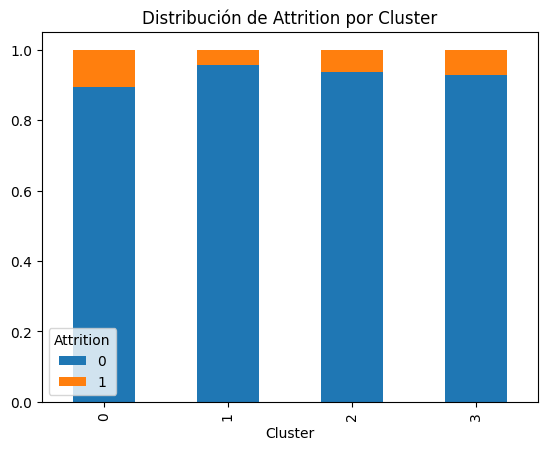

In [15]:
# Análisis descriptivo por cluster
descripcion_clusters = df_clustering.groupby('Cluster').mean()

# Mostrar la descripción
print("Descripción de los clusters:")
print(descripcion_clusters)

# Evaluar la distribución de Attrition entre los clusters
df_clustering['Attrition'] = df_completo['Attrition'].values
attrition_por_cluster = df_clustering.groupby('Cluster')['Attrition'].value_counts(normalize=True).unstack()

# Visualizar la distribución de Attrition por cluster
attrition_por_cluster.plot(kind='bar', stacked=True)
plt.title('Distribución de Attrition por Cluster')
plt.show()


* Cluster 0: Este grupo parece estar compuesto por empleados relativamente jóvenes, con ingresos y años de experiencia moderados, pero con baja satisfacción laboral. Podría ser un grupo en riesgo de rotación debido a la baja satisfacción. Se podrían implementar programas de mejora de la satisfacción laboral, como revisiones salariales, oportunidades de desarrollo profesional, y mejoras en el ambiente laboral.
* Cluster 1: Este grupo incluye empleados más experimentados con muchos años en la fuerza laboral. Aunque tienen una satisfacción moderada, podrían estar menos en riesgo de rotación debido a su estabilidad laboral.
* Cluster 2: Este grupo parece estar compuesto por empleados relativamente jóvenes con ingresos significativamente más altos. La mayor satisfacción laboral podría estar relacionada con los ingresos altos, lo que podría sugerir una menor probabilidad de rotación.
* Cluster 3: Este grupo tiene características similares a las del Cluster 0 en términos de edad y salario, pero con una satisfacción laboral significativamente mayor. Esto podría indicar una menor probabilidad de rotación en comparación con el Cluster 0. Se podría fortalecer aún más este grupo mediante el reconocimiento de su rendimiento y asegurando que las condiciones laborales continúen siendo favorables.

##### Por los resultados arrojados de los clusteres anteriores, procederemos a analizar la satisfacción laboral y su distribución con la variable Atrition.
Mostraremos la distribución de la satisfacción laboral (JobSatisfaction) para los empleados que se quedan (Attrition = 0) y los que se van (Attrition = 1).

<Figure size 1200x600 with 0 Axes>

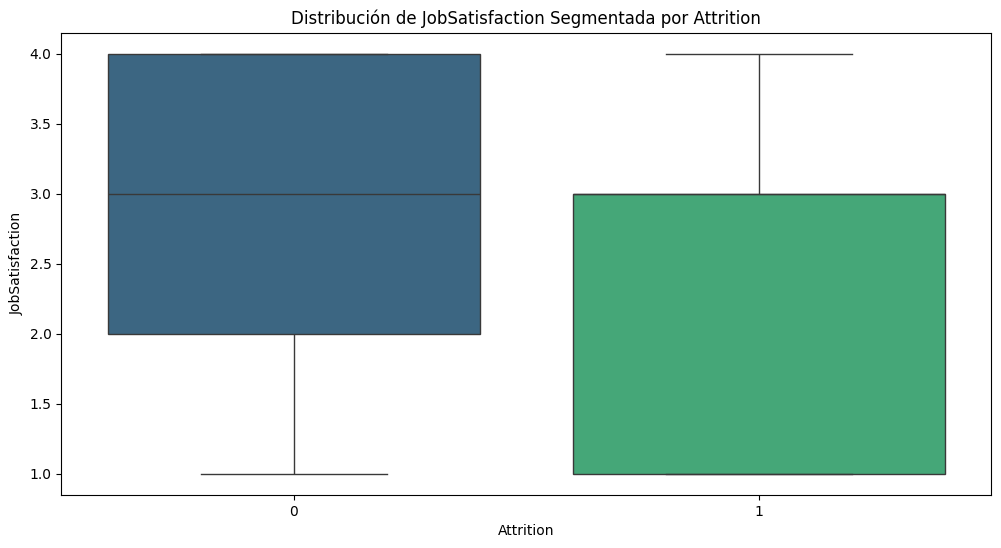

In [16]:
# Configuración del tamaño del gráfico
plt.figure(figsize=(12, 6))

# Gráfico de caja para mostrar la distribución de JobSatisfaction segmentada por Attrition
plt.figure(figsize=(12, 6))
sns.boxplot(x='Attrition', y='JobSatisfaction', data=df_completo, palette="viridis")
plt.title('Distribución de JobSatisfaction Segmentada por Attrition')
plt.xlabel('Attrition')
plt.ylabel('JobSatisfaction')
plt.show()


La baja satisfacción laboral parece estar correlacionada con una mayor probabilidad de rotación. Esto sugiere que las iniciativas para mejorar la satisfacción laboral podrían ser clave para reducir la rotación de empleados


##### Clustering 2
Realizaremos un segundo clustering, mediante una visualización de todas las variables disponibles, y eligiendo un conjunto de variables mas amplio que el anterior.

In [17]:
# Configurar pandas para que muestre todas las columnas
pd.set_option('display.max_columns', None)  # Sin límite en el número de columnas a mostrar
pd.set_option('display.expand_frame_repr', False)  # Evitar que las columnas se dividan en varias líneas

# Mostrar el listado de todas las columnas en df_completo
print(df_completo.columns)

Index(['Age', 'BusinessTravel', 'Department', 'DistanceFromHome', 'Education',
       'EducationField', 'EmployeeID', 'Gender', 'JobLevel', 'JobRole',
       'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked',
       'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'InfoDate', 'EnvironmentSatisfaction',
       'JobSatisfaction', 'WorkLifeBalance', 'DateSurvey', 'JobInvolvement',
       'PerformanceRating', 'SurveyDate', 'Attrition', 'retirementDate',
       'retirementType', 'resignationReason'],
      dtype='object')


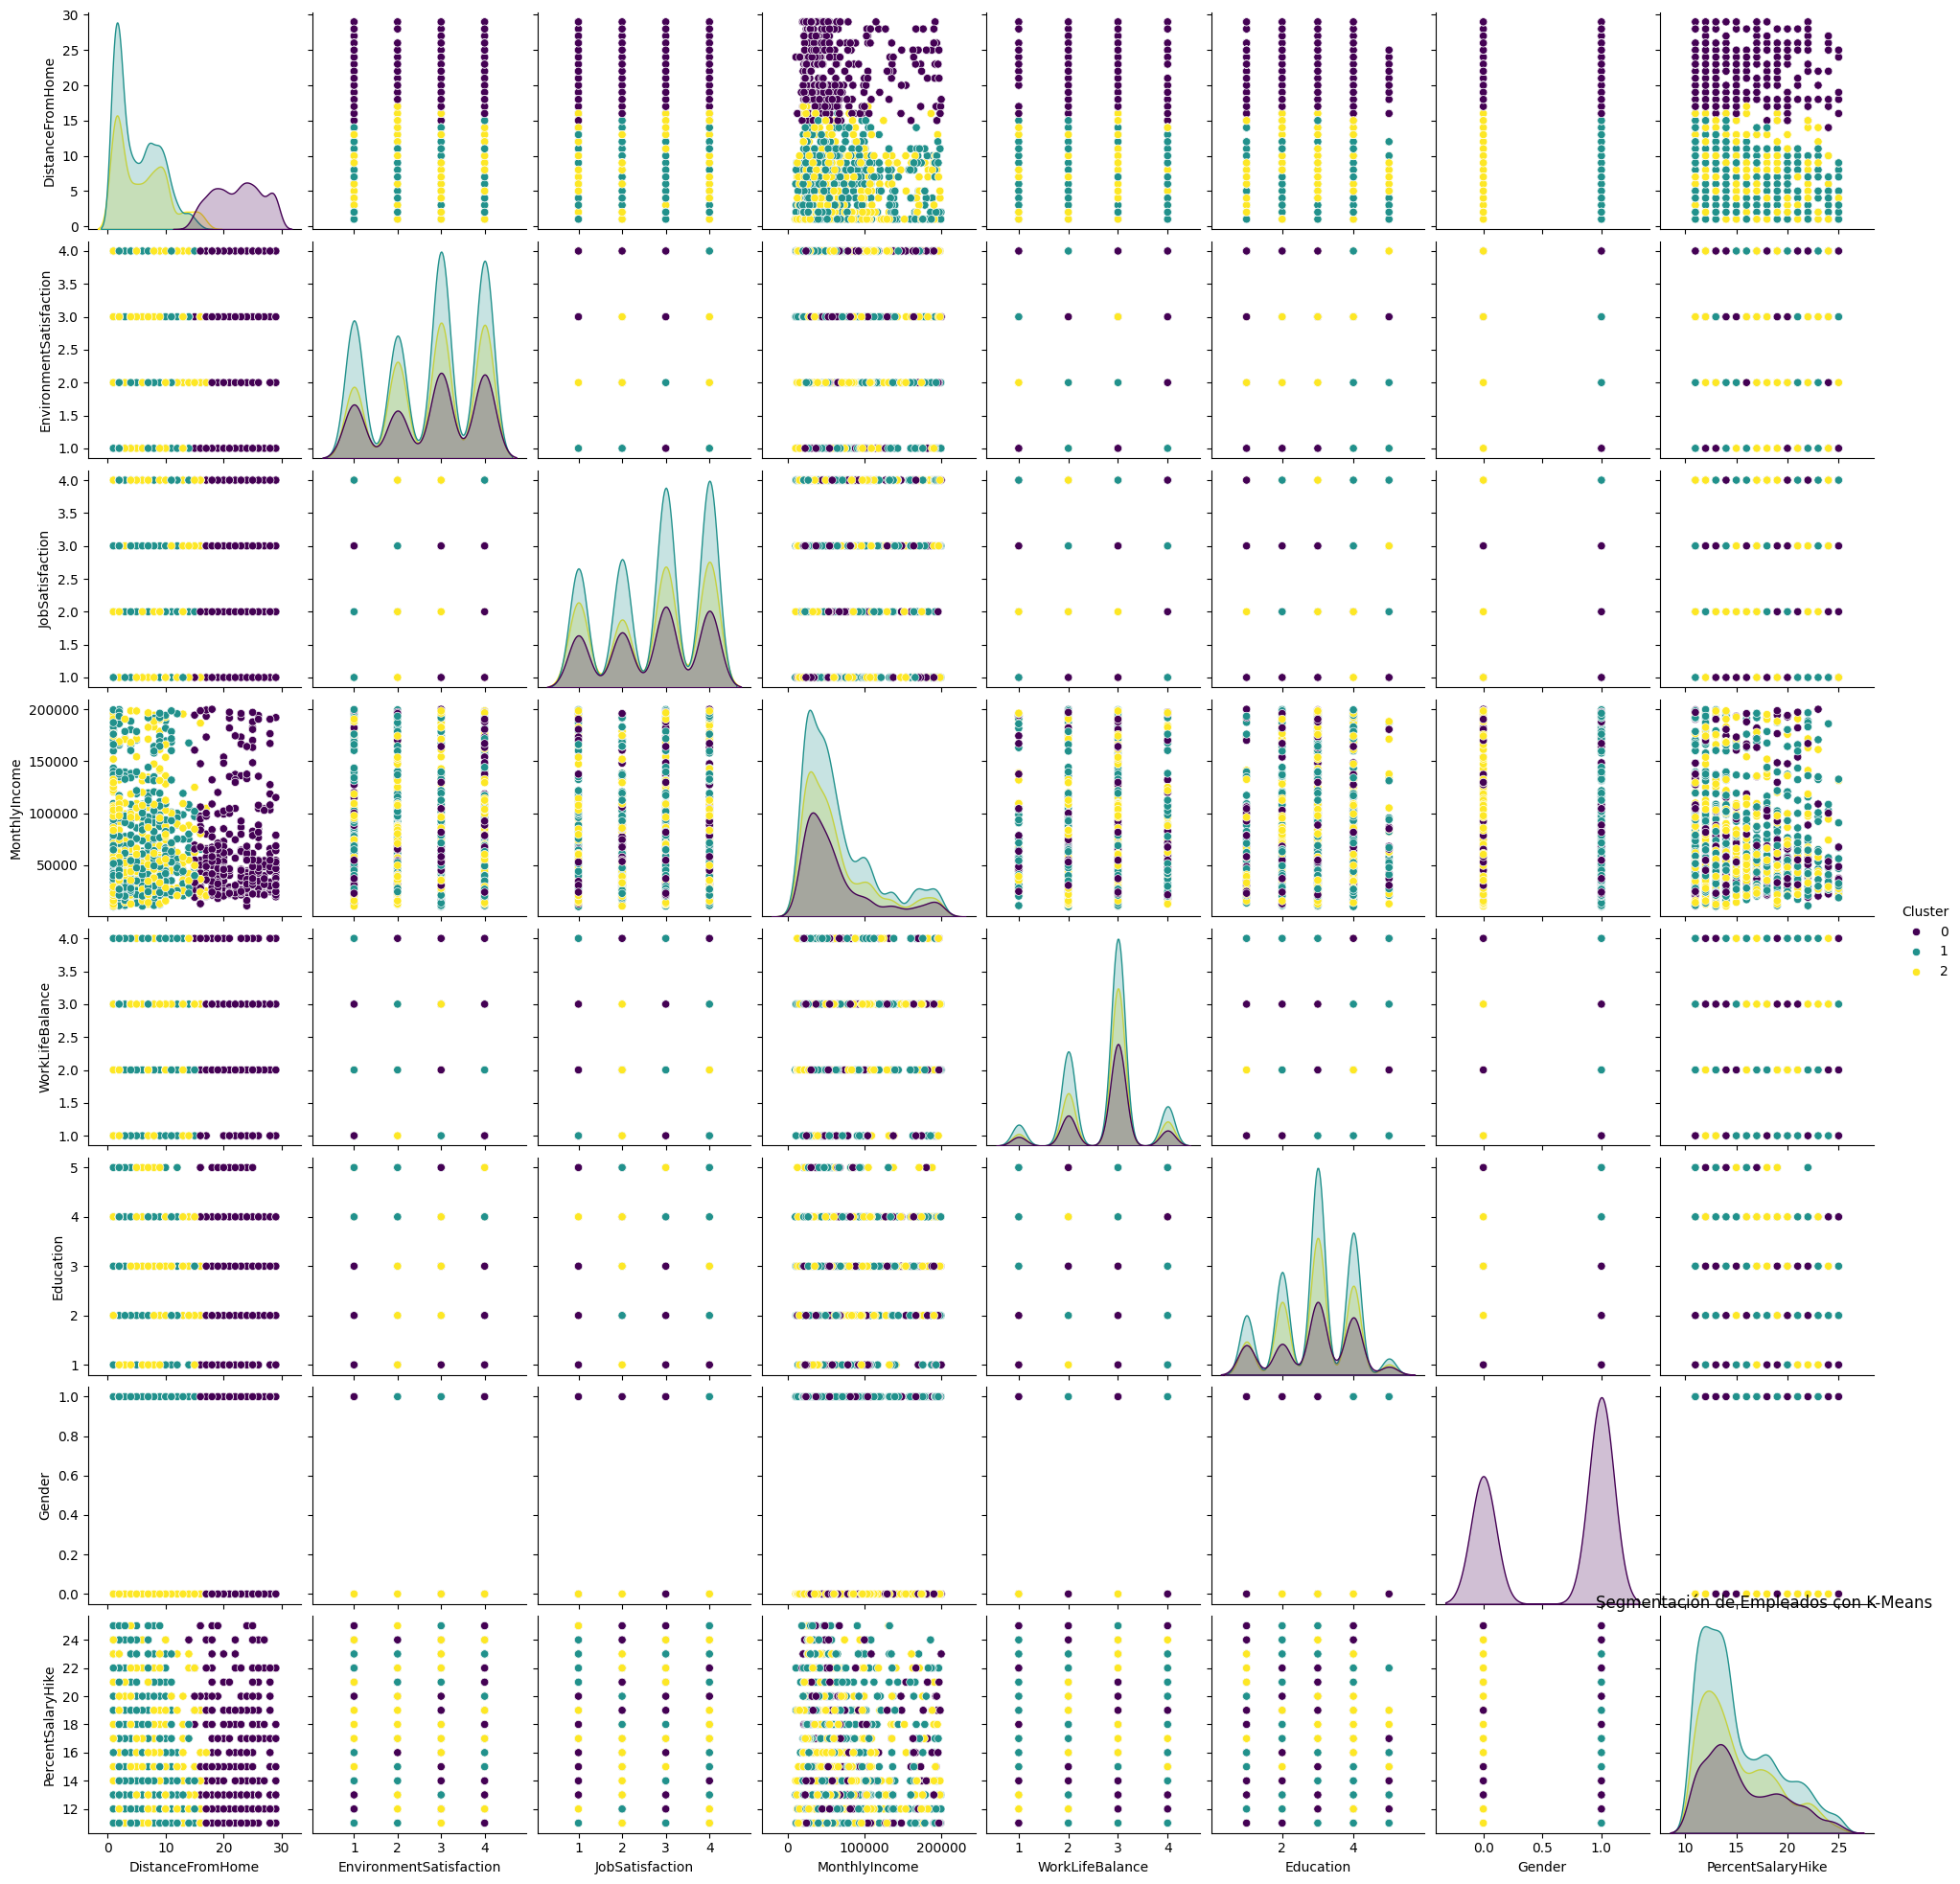

In [18]:
# Selección de las variables para clustering
variables_seleccionadas = ['DistanceFromHome', 'EnvironmentSatisfaction', 'JobSatisfaction',
                           'MonthlyIncome', 'WorkLifeBalance', 'Education',
                           'Gender', 'PercentSalaryHike']

# Crear un nuevo DataFrame con solo las variables seleccionadas
df_clustering = df_completo[variables_seleccionadas].dropna()

# Convertir la columna 'Gender' en numérica
label_encoder = LabelEncoder()
df_clustering['Gender'] = label_encoder.fit_transform(df_clustering['Gender'])

# Preprocesamiento: Escalamiento de los datos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clustering)

# Aplicación de K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Puedes ajustar n_clusters según lo necesario
df_clustering['Cluster'] = kmeans.fit_predict(df_scaled)

# Visualización de los Resultados
sns.pairplot(df_clustering, hue='Cluster', palette='viridis')
plt.title('Segmentación de Empleados con K-Means ')
plt.show()


Descripción de los clusters:
         DistanceFromHome  EnvironmentSatisfaction  JobSatisfaction  MonthlyIncome  WorkLifeBalance  Education    Gender  PercentSalaryHike
Cluster                                                                                                                                    
0               22.437888                 2.736025         2.688406   64574.316770         2.791925   2.916149  0.618012          15.639752
1                5.162518                 2.697901         2.755979   65655.636896         2.732064   2.910688  1.000000          15.076135
2                5.939785                 2.757706         2.718996   64424.430108         2.789964   2.913978  0.000000          15.107527


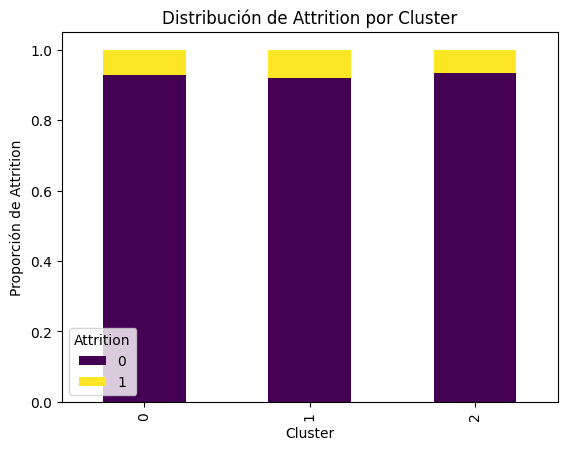

In [19]:
# Análisis descriptivo por cluster
descripcion_clusters = df_clustering.groupby('Cluster').mean()

# Mostrar la descripción
print("Descripción de los clusters:")
print(descripcion_clusters)

# Evaluar la distribución de Attrition entre los clusters
df_clustering['Attrition'] = df_completo['Attrition'].values
attrition_por_cluster = df_clustering.groupby('Cluster')['Attrition'].value_counts(normalize=True).unstack()

# Visualizar la distribución de Attrition por cluster
attrition_por_cluster.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Distribución de Attrition por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proporción de Attrition')
plt.show()

* Cluster 0: Este grupo está compuesto principalmente por empleados que viven lejos de su lugar de trabajo. Aunque tienen un nivel moderado de satisfacción en general, la alta distancia desde el hogar podría ser un factor que contribuye a la rotación. Este cluster podría beneficiarse de iniciativas para reducir el impacto de la distancia desde el hogar, como opciones de trabajo remoto o flexibilidad horaria.
* Cluster 1: Este cluster está compuesto únicamente por mujeres que viven cerca del trabajo y tienen un nivel moderado de satisfacción laboral. Aunque están cerca del trabajo, su satisfacción es comparable a la de los otros clusters.
* Cluster 2: Este grupo está compuesto por hombres que viven cerca del trabajo. Su satisfacción con el entorno y el trabajo es similar a la de los otros clusters.
Dado que la rotación está distribuida uniformemente entre los clusters, las intervenciones deben enfocarse en mejorar la satisfacción laboral y el equilibrio vida-trabajo en toda la empresa